In [122]:
from tqdm.notebook import tqdm_notebook as tqdm
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Questão 1

Considere o conjunto de dados disponível em artificial1d.csv organizado em
duas colunas, x e y. Seja um modelo de regressão linear para y^ = f(x).

In [123]:
df = pd.read_csv('artificial1d.csv', header=None, names=['X', 'y'])
df

,X,y
0,-1.000000,-2.082017
1,-0.931034,-1.326980
2,-0.862069,-1.105598
3,-0.793103,-0.873946
4,-0.724138,-0.285027
5,-0.655172,-0.431153
6,-0.586207,-0.794754
7,-0.517241,-0.886068
8,-0.448276,-0.899900
9,-0.379310,-0.861844


In [124]:
X = np.array(df['X'])
y = np.array(df['y'])
# Normalização de X.
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Garante que X tenha 2 dimensões.
if X.ndim == 1:
    X = X.reshape(-1, 1)
# X para plotagem.
X_plot = X.flatten()

In [125]:
def plot_reta(w: np.ndarray, X: np.ndarray, tipo: str) -> None:
    # Cálculo dos valores preditos.
    y_pred = w[0] + w[1] * X
    plt.scatter(X, y, label='Dados reais', color='blue')
    plt.plot(X, y_pred, label='Regressão Linear', color='red')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'Regressão Linear ({tipo})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [126]:
def plot_eqm(erros: List[float]) -> None:
    plt.plot(erros)
    plt.title('EQM ao longo das épocas')
    plt.xlabel('Época')
    plt.ylabel('Erro Quadrático Médio')
    plt.tight_layout()
    plt.show()

a) Apresente os parâmetros do modelo e o MSE (erro quadrático médio)
 obtidos pelo algoritmo OLS (mínimos quadrados ordinários). 
 Plote a reta resultante sobre os dados.

In [127]:
def regressao_linear_ols(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Implementação da regressão linear pelo método dos mínimos quadrados ordinários (OLS).
    :param X: Matriz de atributos de entrada.
    :param y: Vetor de resultados.
    :return: Vetor de pesos.
    """
    # Está sendo utilizada a pseudoinversa para contornar casos onde X não é invertível.
    pseudoinversa: Callable = np.linalg.pinv
    n: int = len(y)  # Número de entradas.
    # Adiciona uma coluna de uns em X.
    X = np.hstack((np.ones((n, 1)), X))
    # Cálculo dos pesos.
    w: np.ndarray = pseudoinversa(X.T @ X) @ X.T @ y
    y_pred: np.ndarray = X @ w  # Cálculo de y predito.
    e: np.ndarray = y - y_pred  # Cálculo do erro.
    # Cálculo do erro quadrático médio.
    eqm: float = np.mean(e**2) 
    return w, eqm

In [128]:
w, eqm = regressao_linear_ols(X, y)

Parâmetros obtidos:

In [129]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.06761792463834022
w1: 0.9400795351532126


Erro quadrático médio:

In [130]:
print(eqm)

0.21340090132936987


Reta resultante:

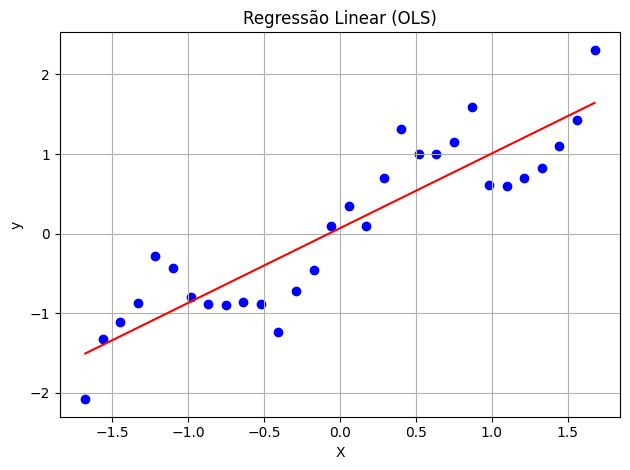

In [131]:
plot_reta(w, X_plot, 'OLS')

b) Apresente os parâmetros do modelo, o MSE e a curva de
aprendizagem obtidos pelo algoritmo GD (gradiente descendente). 
Plote a reta resultante sobre os dados.

In [132]:
def regressao_linear_gd(X: np.ndarray, y: np.ndarray, alpha: float=0.01, epochs: int=1000) -> Tuple[np.ndarray, List[float]]:
    """
    Implementação da regressão linear pelo método do gradiente descendente.
    :param X: matriz de atributos de entrada.
    :param y: vetor de resultados.
    :param alpha: taxa de aprendizado do modelo.
    :param epochs: total de épocas.
    :return: vetor de pesos e lista do EQM ao longo das épocas.
    """
    n: int = len(y)  # Número de entradas.
    eqms: List[float] = []  # Erros quadráticos médios.
    # Adiciona uma coluna de uns em X.
    X = np.hstack((np.ones((n, 1)), X))
    # Inicialização dos pesos.
    w: np.ndarray = np.zeros(X.shape[1])
    for _ in range(epochs):
        y_pred: np.ndarray = X @ w  # Cálculo de y predito.
        e: np.ndarray = y - y_pred  # Cálculo do erro.
        # Cálculo do erro quadrático médio.
        eqm: float = np.mean(e**2) 
        eqms.append(eqm)
        # Atualização dos parâmetros.
        w = w + (alpha/n) * (X.T @ e)
    return w, eqms

In [133]:
w, erros = regressao_linear_gd(X, y)

Parâmetros obtidos:

In [134]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.06761500548818634
w1: 0.9400389507470148


Erro quadrático médio:

In [135]:
print(erros[-1])

0.213400903018601


Curva de aprendizagem:

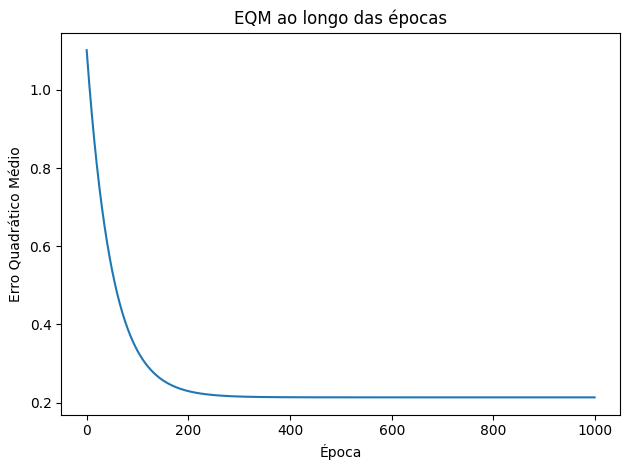

In [136]:
plot_eqm(erros)

Reta resultante:

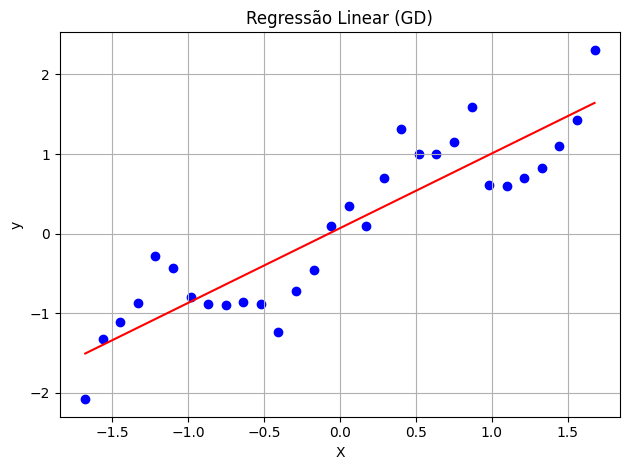

In [137]:
plot_reta(w, X_plot, 'GD')

c) Apresente os parâmetros do modelo, o MSE e a curva de aprendizagem
obtidos pelo algoritmo SGD (gradiente descendente estocástico).
Plote a reta resultante sobre os dados.

In [138]:
def regressao_linear_gde(X: np.ndarray, y: np.ndarray, alpha: float=0.003, epochs: int=100) -> Tuple[np.ndarray, List[float]]:
    """
    Implementação da regressão linear pelo método do gradiente descendente estocástico.
    :param X: matriz de atributos de entrada.
    :param y: vetor de resultados.
    :param alpha: taxa de aprendizado do modelo.
    :param epochs: total de épocas.
    :return: vetor de pesos e lista do EQM ao longo das épocas.
    """
    n: int = len(y)  # Número de entradas.
    eqms: List[float] = []  # Erros quadráticos médios.
    # Adiciona uma coluna de uns em X.
    X = np.hstack((np.ones((n, 1)), X))
    # Inicialização dos pesos.
    w: np.ndarray = np.zeros(X.shape[1])
    for epoch in range(epochs):
        idx = np.random.permutation(n)
        # Embaralhamento de X e y.
        X = X[idx]
        y = y[idx]
        for xi, yi in zip(X, y):
            y_i_pred: np.ndarray = xi @ w  # Cálculo de yi predito.
            e_i: np.ndarray = yi - y_i_pred  # Cálculo do erro.
            # Atualização dos parâmetros.
            w += alpha * xi * e_i
            # Cálculo do erro quadrático médio.            
            y_pred: np.ndarray = X @ w  # Cálculo de y predito.
            e: np.ndarray = y - y_pred  # Cálculo do erro.
            eqm: float = np.mean(e**2) 
            eqms.append(eqm)
    return w, eqms

In [139]:
w, erros = regressao_linear_gde(X, y)

Parâmetros obtidos:

In [140]:
_ = [print(f'w{i}: {w[i]}') for i in range(len(w))]

w0: 0.0681561064736118
w1: 0.9401591354871179


Erro quadrático médio:

In [141]:
print(erros[-1])

0.21340119730527085


Curva de aprendizagem:

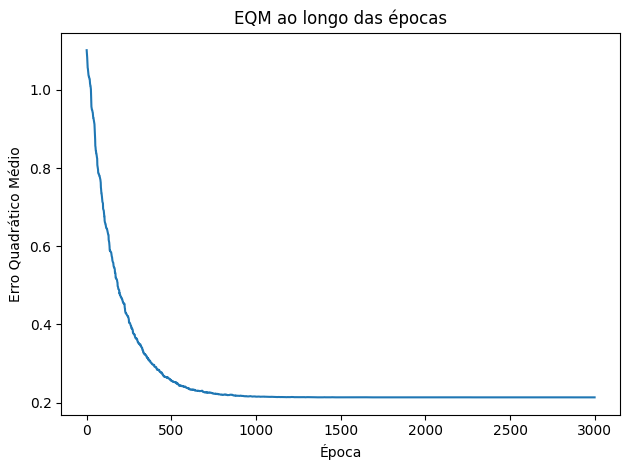

In [142]:
plot_eqm(erros)

Reta resultante:

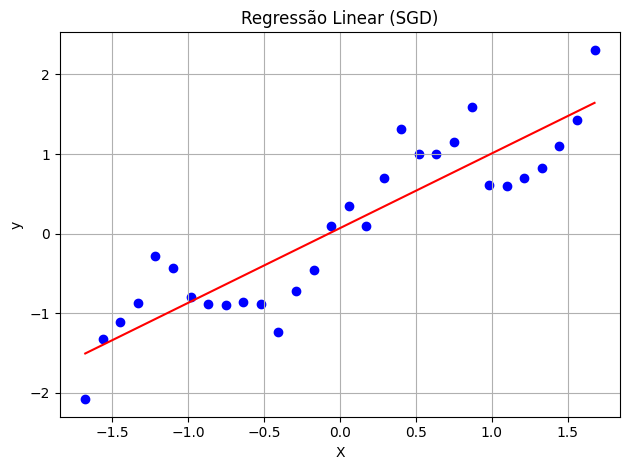

In [143]:
plot_reta(w, X_plot, 'SGD')

# Questão 2
Considere o conjunto de dados disponível em california.csv, organizado em 9
colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída.
Os 8 atributos são usados na predição da mediana de preços de casas em dis
tritos da Califórnia na década de 1990. Maiores detalhes sobre os dados po
dem ser conferidos em https://scikit-learn.org/stable/datasets/real_
world.html#california-housing-dataset.

In [144]:
names = [f'X{i}' for i in range(1, 9)] + ['y']
df = pd.read_csv('california.csv', header=None, names=names)
df

,X1,X2,X3,X4,X5,X6,X7,X8,y
0,4.1685,20.0,6.700637,1.178344,745.0,2.372611,38.80,-121.15,2.175
1,2.8194,24.0,4.762500,1.020833,608.0,2.533333,36.75,-119.85,0.811
2,2.4250,46.0,4.927711,1.018072,772.0,2.325301,36.33,-119.31,0.849
3,3.1205,16.0,3.728477,1.101545,1260.0,2.781457,33.87,-117.99,1.740
4,4.3889,41.0,5.741007,1.199041,837.0,2.007194,34.15,-118.40,3.804
...,...,...,...,...,...,...,...,...,...
995,4.6076,6.0,4.665773,1.087578,2597.0,2.320822,33.66,-117.64,2.040
996,5.1909,16.0,6.671779,1.003067,1037.0,3.180982,32.99,-117.09,2.014
997,4.7308,35.0,5.666667,0.971831,601.0,2.821596,33.83,-118.37,3.534
998,4.2788,10.0,5.375000,1.114583,282.0,2.937500,33.68,-117.35,1.250


In [145]:
X = np.array(df[[f'X{i}' for i in range(1, 9)]])
y = np.array(df['y'])
# Normalização de X.
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Garante que X tenha 2 dimensões.
# if X.ndim == 1:
# #     X = X.reshape(-1, 1)
# # X para plotagem.
# X_plot = X.flatten()

a) Aleatoriamente, divida o conjunto de dados em treino (80%) e teste (20%).

In [146]:
n: int = len(y)  # Número de entradas.
idx = np.random.permutation(n)
# Embaralhamento de X e y.
X = X[idx]
y = y[idx]
# Cálculo do índice separador.
sep = int(len(X) * 0.2)
X_train, X_test = X[sep:], X[:sep]

b) Treine 13 modelos de regressão polinomial, com ordens de 1 a 13. 
Você pode usar o algoritmo OLS.

In [147]:
def regressao_polinomial(X: np.ndarray, y: np.ndarray, grau: int = 1, algoritmo: str = 'OLS', 
                         alpha: float=0.01, epochs: int=1000) -> Tuple[np.ndarray, List[float]|float]:
    """
    Implementação da regressão polinomial, que cria polinômios até certo grau para gerar mais informação ao modelo.
    :param X: Matriz de atributos de entrada.
    :param y: Vetor de resultados.
    :param grau: Grau máximo para as potências.
    :param algoritmo: Algoritmo a ser utilizado para cálculo dos pesos. Pode ser 'OLS', 'GD' ou 'GDE'.
    :param alpha: Taxa de aprendizado do modelo.
    :param epochs: Total de épocas.
    :return: Tetor de pesos e lista do EQM ao longo das épocas.
    """
    concatena: Callable = np.column_stack
    new_X = X.copy()  # Cria uma cópia de X.
    # Concatena as potências de X.
    for i in range(2, grau+1):
        new_X = concatena((new_X, X**i))
        
    if algoritmo == 'OLS':
        return regressao_linear_ols(new_X, y)
    elif algoritmo == 'GD':
        return regressao_linear_gd(new_X, y, alpha, epochs)
    elif algoritmo == 'GDE':
        return regressao_linear_gde(new_X, y, alpha, epochs)
    else:
        raise ValueError(f'Algoritmo [{algoritmo}] não implementado.')

In [149]:
algoritmo = 'OLS' 
ws: List[np.array] = []  # Lista de arrays de pesos.
eqms: List[List[float]] = []  # Lista de listas dos eqms.
for grau in tqdm(range(1, 14)):
    w, eqm = regressao_polinomial(X, y, grau, algoritmo)
    ws.append(w)
    eqms.append(eqm)

  0%|          | 0/13 [00:00<?, ?it/s]